In [ ]:
# Train BC and DAgger in env
# Show perfromance on different iterations
# Repeat for different envs
# Test Soft activations

In [12]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sim_util import run_torch_sim
import gym
gym.logger.set_level(40)

In [2]:
def training_loop(loader_train, model, optimizer, epochs=1, print_every=1):
    criterion = nn.MSELoss()
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()
            scores = model(x)
            loss = criterion(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [17]:
def train_model(dim_in, dim_out, observations, actions, epochs=45):
    num_train = len(observations)

    observations_tensor = torch.from_numpy(observations).float()
    actions_tensor = torch.from_numpy(actions).float()
    dataset = torch.utils.data.TensorDataset(observations_tensor, actions_tensor)
    loader_train = torch.utils.data.DataLoader(dataset, batch_size=128, 
                              sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_train)))

    model = nn.Sequential(
        nn.Linear(dim_in, 30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.ReLU(),
        nn.Linear(15, dim_out)
    )

    model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loop(loader_train, model, optimizer, epochs=epochs)
    return model

In [96]:
def behavioral_cloning(dim_in, dim_out, observations, actions, env_name, roll_out_len, roll_out_steps):
    returns = []
    i = 0
    while i < len(observations):
        i = i + roll_out_len * roll_out_steps
        obs_short = observations[:i]
        act_short = actions[:i]
        model = train_model(dim_in, dim_out, obs_short, act_short)
        _, new_returns = run_torch_sim(model, env_name, num_rollouts=20)
        returns.append(new_returns)
        
    return model, returns

In [171]:
import os
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy

def get_expert_data(states, expert_fn):
    with tf.Session():
        tf_util.initialize()
        expert_labels = []
        expert_labels = expert_fn(states)
        
    return expert_labels

def DAgger(dim_in, dim_out, observations, actions, env, expert_policy_file, iterations=10, 
           num_rollouts=20, epochs=45):
    expert_fn = load_policy.load_policy(expert_policy_file)
    returns = []
    for i in range(iterations):
        model = train_model(dim_in, dim_out, observations, actions, epochs=epochs)
        new_actions, new_returns = run_torch_sim(model, env, num_rollouts=num_rollouts)
        returns.append(new_returns)
        expert_labels = get_expert_data(new_actions['observations'], expert_fn)
        observations = np.concatenate((observations, new_actions['observations']), axis=0)
        actions = np.concatenate((actions, expert_labels), axis=0)
        print("Iteration %d" % i)
    
    return model, returns

In [127]:
def get_model(dim_in, dim_out):
    model = nn.Sequential(
        nn.Linear(dim_in, 30),
        nn.ReLU(),
        nn.Linear(30, 15),
        nn.ReLU(),
        nn.Linear(15, dim_out)
    )

    model.apply(init_weights)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    return model, optimizer

def get_loader(observations, actions):
    num_train = len(observations)

    observations_tensor = torch.from_numpy(observations).float()
    actions_tensor = torch.from_numpy(actions).float()
    dataset = torch.utils.data.TensorDataset(observations_tensor, actions_tensor)
    loader_train = torch.utils.data.DataLoader(dataset, batch_size=128, 
                              sampler=torch.utils.data.sampler.SubsetRandomSampler(range(num_train)))
    
    return loader_train

In [167]:
def DAgger_continuous(observations, actions, env, expert_policy_file, iterations=10, num_rollouts=20, epochs=45):
    expert_fn = load_policy.load_policy(expert_policy_file)
    returns = []
    model, optimizer = get_model(observations.shape[1], actions.shape[1])
    for i in range(iterations):
        loader = get_loader(observations, actions)
        training_loop(loader, model, optimizer, epochs=epochs)
        new_actions, new_returns = run_torch_sim(model, env, num_rollouts=num_rollouts)
        returns.append(new_returns)
        expert_labels = get_expert_data(new_actions['observations'], expert_fn)
        observations = np.concatenate((observations, new_actions['observations']), axis=0)
        actions = np.concatenate((actions, expert_labels), axis=0)
        print("Iteration %d" % i)
        
    return model, returns

## Reacher-v2

In [135]:
expert_mean_score = -3.90752964581997
env_name = "Reacher-v2"

### Behavioural cloning

In [136]:
pickle_in = open("expert_data/Reacher-v2_1000.pkl","rb")
reacher_expert = pickle.load(pickle_in)

observations = reacher_expert['observations']

actions = reacher_expert['actions']
actions = actions.reshape(-1, 2)
observations.shape, actions.shape

((50000, 11), (50000, 2))

In [31]:
### This was run only on the half !!! 
model_bc_reacher, returns_bc_reacher = behavioral_cloning(11, 2, observations, actions, env_name, 50, 10)

In [41]:
torch.save(model_bc_reacher, open("policies/" + env_name + "_bc.md", 'wb'))
pickle.dump(returns_bc_reacher, open("policies/" + env_name + "_bc_returns.md", 'wb'))

### DAgger

In [137]:
# Get initial expert data:
pickle_in = open("expert_data/Reacher-v2.pkl","rb")
reacher_expert = pickle.load(pickle_in)

observations = reacher_expert['observations']

actions = reacher_expert['actions']
actions = actions.reshape(-1, 2)
observations.shape, actions.shape

((1000, 11), (1000, 2))

In [44]:
model_dagger_reacher, returns_dagger_reacher = DAgger(11, 2, observations, actions, env_name, 
                        'experts/Reacher-v2.pkl', iterations=50, num_rollouts=10)


obs (1, 11) (1, 11)
Instructions for updating:
Please use tf.global_variables instead.

Instructions for updating:
Use `tf.variables_initializer` instead.


/home/raznem/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [105]:
torch.save(model_dagger_reacher, open("policies/" + env_name + "_dagger.md", 'wb'))
pickle.dump(returns_dagger_reacher, open("policies/" + env_name + "_dagger_returns.md", 'wb'))

In [139]:
model_dagger_cont_reacher, returns_dagger_cont_reacher = DAgger_continuous(observations, actions, env_name, 
                        'experts/Reacher-v2.pkl', iterations=50, num_rollouts=10, epochs=45)

obs (1, 11) (1, 11)


In [140]:
torch.save(model_dagger_cont_reacher, open("policies/" + env_name + "_dagger_cont.md", 'wb'))
pickle.dump(returns_dagger_cont_reacher, open("policies/" + env_name + "_dagger_cont_returns.md", 'wb'))

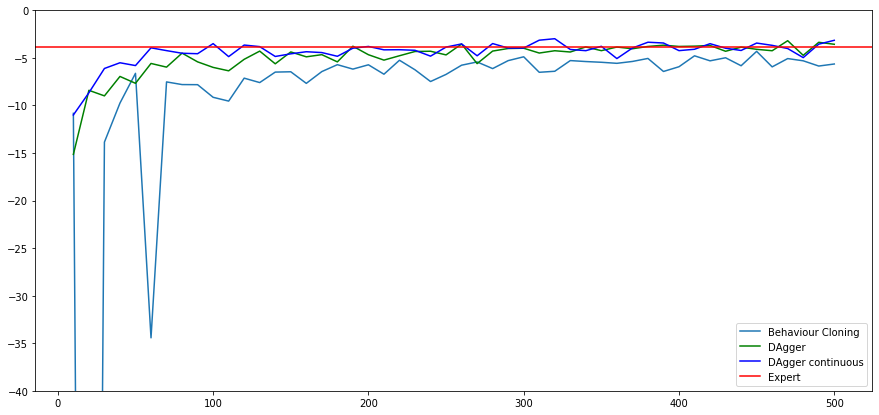

In [141]:
# plt.plot([np.mean(x) for x in returns_bc_reacher])
plt.figure(figsize=(15,7))
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_reacher],
        label="Behaviour Cloning")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_reacher], 
         color='g', label="DAgger")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_cont_reacher], 
         color='b', label="DAgger continuous")
plt.axhline(expert_mean_score, color='r', label="Expert")
plt.ylim(-40, 0)
plt.title(env_name)
plt.legend()
plt.show()

## Hopper

In [160]:
expert_mean_score = 3778.02
env_name = "Hopper-v2"

### Behavioural cloning

In [110]:
pickle_in = open("expert_data/Hopper-v2_500.pkl","rb")
hopper_expert = pickle.load(pickle_in)

observations = hopper_expert['observations']

actions = hopper_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((500000, 11), (500000, 3))

In [111]:
roll_out_len = observations.shape[0] // 500

In [113]:
model_bc_hopper, returns_bc_hopper = behavioral_cloning(observations.shape[1], actions.shape[1], 
                                                        observations, actions, 
                                                        env_name, roll_out_len, roll_out_steps=10)

100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
3

200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/10

400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
90

300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
2

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000


700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000

300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000


In [114]:
torch.save(model_bc_hopper, open("policies/" + env_name + "_bc.md", 'wb'))
pickle.dump(returns_bc_hopper, open("policies/" + env_name + "_bc_returns.md", 'wb'))

### DAgger

In [161]:
# Get initial expert data:
pickle_in = open("expert_data/Hopper-v2.pkl","rb")
hopper_expert = pickle.load(pickle_in)

observations = hopper_expert['observations']

actions = hopper_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((20000, 11), (20000, 3))

In [116]:
model_dagger_hopper, returns_dagger_hopper = DAgger(observations.shape[1], actions.shape[1], observations, actions,
                        env_name, 'experts/Hopper-v2.pkl', iterations=50, num_rollouts=10)

obs (1, 11) (1, 11)
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000

1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000

300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000

1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000

500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000

In [117]:
torch.save(model_dagger_hopper, open("policies/" + env_name + "_dagger.md", 'wb'))
pickle.dump(returns_dagger_hopper, open("policies/" + env_name + "_dagger_returns.md", 'wb'))

In [174]:
model_dagger_hopper_small, returns_dagger_hopper_small = DAgger(observations.shape[1], actions.shape[1], 
                        observations, actions, env_name, 'experts/Hopper-v2.pkl', 
                        iterations=50, num_rollouts=10, epochs=5)

obs (1, 11) (1, 11)


/home/raznem/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Iteration 0
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
Iteration 1
100/1000
Iteration 2
Iteration 3
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
Iteration 4
100/1000
100/1000
200/1000
300/1000
100/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
100/1000
200/1000
300/1000
400/1000
100/1000
100/1000
100/1000
200/1000
Iteration 5
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
Iteration 6
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
Iteration 7
100/1000
200/1000
300/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/

600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
Iteration 25
100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
Iteration 26
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/10

600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 36
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/

400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
Iteration 46
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/10

In [175]:
model_dagger_cont_hopper, returns_dagger_cont_hopper = DAgger_continuous(observations, actions, env_name, 
                        'experts/Hopper-v2.pkl', iterations=50, num_rollouts=10, epochs=5)

obs (1, 11) (1, 11)
100/1000
200/1000
100/1000
100/1000
100/1000
200/1000
Iteration 0
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
Iteration 1
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
Iteration 2
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
Iteration 3
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
Iteration 4
100/1000
200/1000
100/1000
200/1000
100/1000
200/1000
10

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 14
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/

400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 23
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/

500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 32
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/

500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 41
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/

In [169]:
torch.save(model_dagger_cont_hopper, open("policies/" + env_name + "_dagger_cont.md", 'wb'))
pickle.dump(returns_dagger_cont_hopper, open("policies/" + env_name + "_dagger_cont_returns.md", 'wb'))

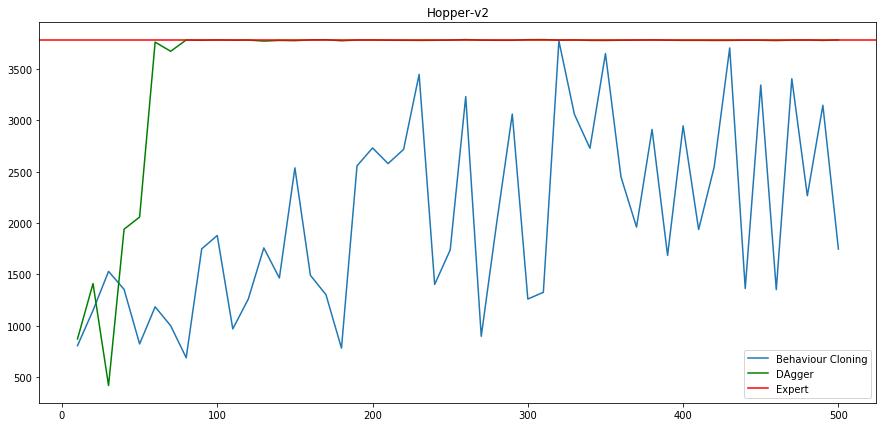

In [172]:
# plt.plot([np.mean(x) for x in returns_bc_reacher])
plt.figure(figsize=(15,7))
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_hopper],
        label="Behaviour Cloning")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_hopper], 
         color='g', label="DAgger")
# plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_cont_hopper], 
#          color='b', label="DAgger continuous")
plt.axhline(expert_mean_score, color='r', label="Expert")
# plt.ylim(-40, 0)
plt.legend()
plt.title(env_name)
plt.show()

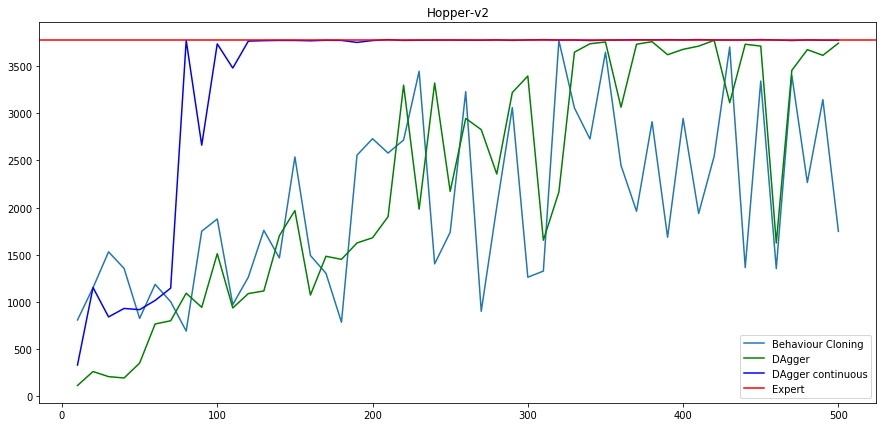

In [176]:
# plt.plot([np.mean(x) for x in returns_bc_reacher])
plt.figure(figsize=(15,7))
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_hopper],
        label="Behaviour Cloning")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_hopper_small], 
         color='g', label="DAgger")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_cont_hopper], 
         color='b', label="DAgger continuous")
plt.axhline(expert_mean_score, color='r', label="Expert")
# plt.ylim(-40, 0)
plt.legend()
plt.title(env_name)
plt.show()

## Ant

In [188]:
expert_mean_score = 4861.16
env_name = "Ant-v2"

### Behavioural cloning

In [120]:
pickle_in = open("expert_data/Ant-v2_500.pkl","rb")
obs_expert = pickle.load(pickle_in)

observations = obs_expert['observations']

actions = obs_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((491981, 111), (491981, 8))

In [121]:
roll_out_len = observations.shape[0] // 500

In [122]:
model_bc_ant, returns_bc_ant = behavioral_cloning(observations.shape[1], actions.shape[1], observations, 
                                                  actions, env_name, roll_out_len, 10)

100/1000
200/1000
300/1000
400/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000


500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000

800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000

100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000


800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000

800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000

200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000

800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000

400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000

In [187]:
torch.save(model_bc_ant, open("policies/" + env_name + "_bc.md", 'wb'))
pickle.dump(returns_bc_ant, open("policies/" + env_name + "_bc_returns.md", 'wb'))

### DAgger

In [189]:
# Get initial expert data:
pickle_in = open("expert_data/Ant-v2.pkl","rb")
obs_expert = pickle.load(pickle_in)

observations = obs_expert['observations']

actions = obs_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((497737, 111), (497737, 8))

In [190]:
model_dagger_ant, returns_dagger_ant = DAgger(observations.shape[1], actions.shape[1], 
                                              observations, actions, env_name, 
                        'experts/Ant-v2.pkl', iterations=50, num_rollouts=10, epochs=5)

obs (1, 111) (1, 111)


KeyboardInterrupt: 

In [ ]:
torch.save(model_dagger_ant, open("policies/" + env_name + "_dagger.md", 'wb'))
pickle.dump(returns_dagger_ant, open("policies/" + env_name + "_dagger_returns.md", 'wb'))

In [193]:
model_dagger_cont_ant, returns_dagger_cont_ant = DAgger_continuous(observations, actions, env_name, 
                        'experts/Ant-v2.pkl', iterations=5, num_rollouts=10, epochs=1)

obs (1, 111) (1, 111)
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Iteration 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
70

In [199]:
torch.save(model_dagger_cont_ant, open("policies/" + env_name + "_dagger_cont.md", 'wb'))
pickle.dump(returns_dagger_cont_ant, open("policies/" + env_name + "_dagger_cont_returns.md", 'wb'))

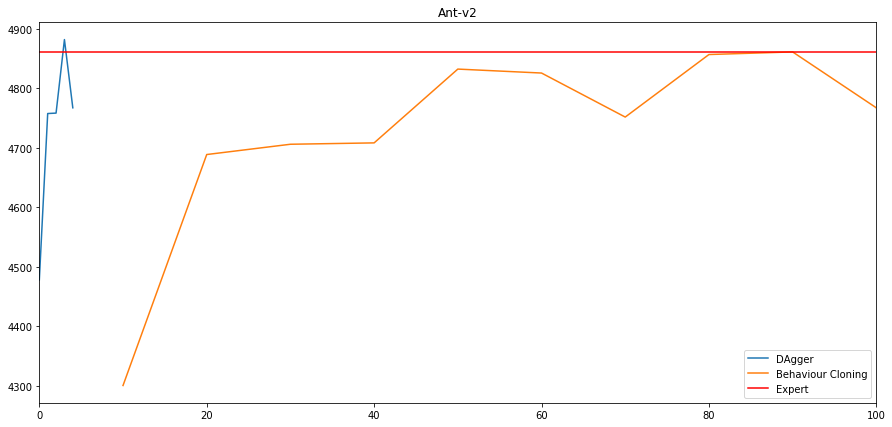

In [202]:
plt.figure(figsize=(15,7))
plt.plot([np.mean(x) for x in returns_dagger_cont_ant], label="DAgger")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_ant[:-1]],
        label="Behaviour Cloning")
plt.axhline(expert_mean_score, color='r', label="Expert")
plt.legend()
plt.title(env_name)
plt.xlim((0, 100))
plt.show()

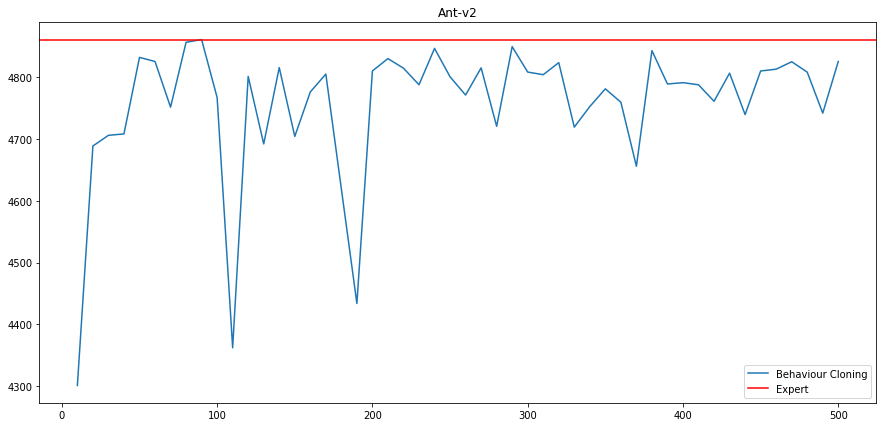

In [158]:
# plt.plot([np.mean(x) for x in returns_bc_reacher])
plt.figure(figsize=(15,7))
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_ant[:-1]],
        label="Behaviour Cloning")
# plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_ant], 
#          color='g', label="DAgger")
plt.axhline(expert_mean_score, color='r', label="Expert")
# plt.ylim(-40, 0)
plt.legend()
plt.title(env_name)
plt.show()

## Walker2d

In [182]:
expert_mean_score = 5522.5315978874805
env_name = "Walker2d-v2"

### Behavioural cloning

In [183]:
pickle_in = open("expert_data/Walker2d-v2_500.pkl","rb")
obs_expert = pickle.load(pickle_in)

observations = obs_expert['observations']

actions = obs_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

((499936, 17), (499936, 6))

In [184]:
roll_out_len = observations.shape[0] // 500

In [185]:
model_bc_walker2d, returns_bc_walker2d = behavioral_cloning(observations.shape[1], actions.shape[1], observations,
                                                            actions, env_name, roll_out_len, 10)

100/1000
100/1000
100/1000
100/1000
100/1000
100/1000
200/1000
300/1000
100/1000
200/1000
300/1000
100/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
100/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
100/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/

500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
100/1000
200/1000
300/1000
400/1000

KeyboardInterrupt: 

In [ ]:
torch.save(model_bc_walker2d, open("policies/" + env_name + "_bc.md", 'wb'))
pickle.dump(returns_bc_walker2d, open("policies/" + env_name + "_bc_returns.md", 'wb'))

### DAgger

In [ ]:
# Get initial expert data:
pickle_in = open("expert_data/Walker2d-v2.pkl","rb")
obs_expert = pickle.load(pickle_in)

observations = obs_expert['observations']

actions = obs_expert['actions']
actions = actions.reshape(-1, actions.shape[2])
observations.shape, actions.shape

In [ ]:
model_dagger_walker2d, returns_dagger_walker2d = DAgger(observations.shape[1], actions.shape[1], observations, 
                        actions, env_name, 'experts/Walker2d-v2.pkl', iterations=50, num_rollouts=10)

In [ ]:
torch.save(model_dagger_walker2d, open("policies/" + env_name + "_dagger.md", 'wb'))
pickle.dump(returns_dagger_walker2d, open("policies/" + env_name + "_dagger_returns.md", 'wb'))

In [ ]:
# plt.plot([np.mean(x) for x in returns_bc_reacher])
plt.figure(figsize=(15,7))
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_bc_walker2d],
        label="Behaviour Cloning")
plt.plot(np.linspace(roll_out_steps, 500, 500 // roll_out_steps), [np.mean(x) for x in returns_dagger_walker2d], 
         color='g', label="DAgger")
plt.axhline(expert_mean_score, color='r', label="Expert")
# plt.ylim(-40, 0)
plt.legend()
plt.show()

In [ ]:
print(1)